In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data  as pdr
import statsmodels.api as sm

from sklearn.decomposition import PCA

In [311]:
start = '2014-10-31'
end = '2024-12-31'
tickers = ['ARKK', 'TLT', 'IEF', 'SHY']
data = pd.read_csv('data/duration_hedge_prices.csv', index_col=0, parse_dates=True).drop(columns=['^IRX'])

In [312]:
returns = data.pct_change().dropna()
window = 126
hedging_tickers = ['TLT', 'IEF', 'SHY']

In [314]:
data.head()

,ARKK,IEF,SHY,TLT
Date,,,,
2014-10-31,20.379999,105.019997,84.699997,119.250000
2014-11-03,20.379999,104.800003,84.660004,118.959999
2014-11-04,20.260000,104.790001,84.650002,119.330002
2014-11-05,20.000000,104.820000,84.629997,119.160004
2014-11-06,20.139999,104.500000,84.610001,118.389999


last Rolling Betas:
 ARKK Beta vs TLT    0.128417
ARKK Beta vs IEF    0.316033
ARKK Beta vs SHY    1.959139
Name: 2024-12-30 00:00:00, dtype: float64

last Rolling R²:
 R² vs TLT    0.002183
R² vs IEF    0.002733
R² vs SHY    0.010945
Name: 2024-12-30 00:00:00, dtype: float64

Correlation Matrix:
           ARKK       IEF       SHY       TLT
ARKK  1.000000 -0.003346  0.034842 -0.027224
IEF  -0.003346  1.000000  0.781452  0.917578
SHY   0.034842  0.781452  1.000000  0.577102
TLT  -0.027224  0.917578  0.577102  1.000000

OLS Hedge Weights:
 const    0.000698
TLT     -0.244774
IEF      0.225954
SHY      1.431581
dtype: float64


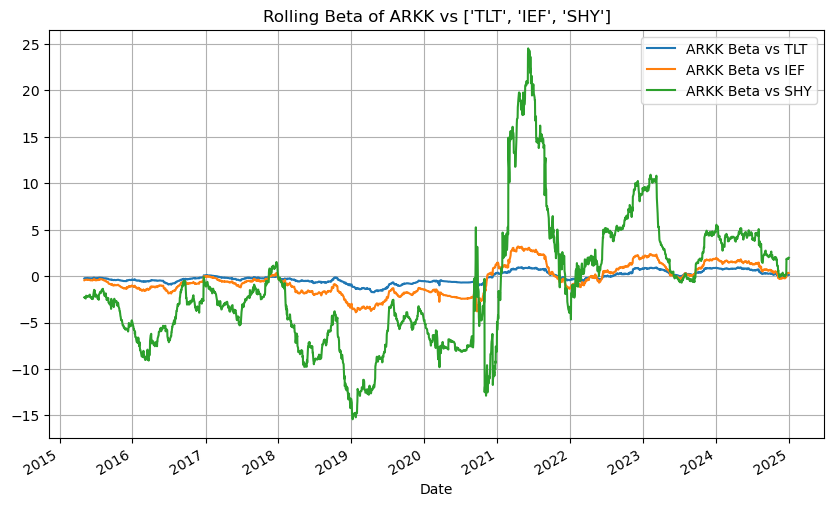

In [315]:
# Step 4: Compute rolling beta and R²
rolling_betas = pd.DataFrame(index=returns.index)
rolling_rsquared = pd.DataFrame(index=returns.index)

for hedge_asset in hedging_tickers:
    cov = returns['ARKK'].rolling(window).cov(returns[hedge_asset])
    var = returns[hedge_asset].rolling(window).var()
    rolling_betas[f'ARKK Beta vs {hedge_asset}'] = cov / var

    # Rolling R² using rolling OLS regression
    def rolling_r2(x):
        x = x.reshape(-1, 2)
        y = x[:, 0]
        X = sm.add_constant(x[:, 1])
        model = sm.OLS(y, X).fit()
        return model.rsquared

    combined = returns[['ARKK', hedge_asset]].dropna().to_numpy()
    rolling_rsq = pd.Series(
        [rolling_r2(combined[i - window:i]) for i in range(window, len(combined) + 1)],
        index=returns.index[window - 1:]
    )
    rolling_rsquared[f'R² vs {hedge_asset}'] = rolling_rsq

# Step 5: Correlation matrix
correlation_matrix = returns.corr()

# Step 6: Static hedge via OLS
Y = returns['ARKK']
X = sm.add_constant(returns[hedging_tickers])
model = sm.OLS(Y, X).fit()
hedge_weights = model.params

# Print results
print("last Rolling Betas:\n", rolling_betas.iloc[-1])
print("\nlast Rolling R²:\n", rolling_rsquared .iloc[-1])
print("\nCorrelation Matrix:\n", correlation_matrix)
print("\nOLS Hedge Weights:\n", hedge_weights)

# Optional: Plot
rolling_betas.plot(title=f'Rolling Beta of ARKK vs {hedging_tickers}', figsize=(10, 6))
plt.grid(True)
plt.show()

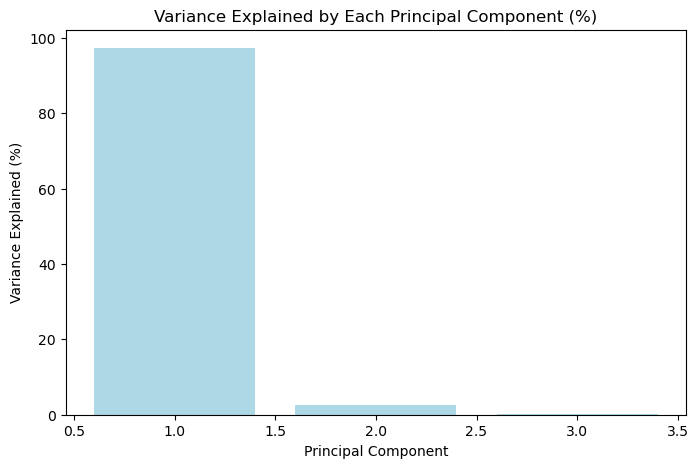


Explained Variance Ratios:
[0.97258825 0.02535566 0.00205609]

Principal Components (Factor Loadings):
          TLT       IEF       SHY
PC1  0.921632  0.383451  0.059659
PC2 -0.375246  0.841408  0.388874
PC3  0.098917 -0.380785  0.919357

Correlation with ARKK:
PC1   -0.023497
PC2    0.059426
PC3    0.024332
dtype: float64


In [316]:

pca_n_components = 3

rate_returns = returns[hedging_tickers]
pca = PCA(n_components=pca_n_components)
pca.fit(rate_returns)

# Step 4: Extract results
explained_variance = pca.explained_variance_ratio_
components = pd.DataFrame(pca.components_, columns=[hedging_tickers], index=[f'PC{i+1}' for i in range(pca_n_components)])

# Step 5: Project ARKK returns onto PCA components
transformed = pca.transform(rate_returns)
pca_returns = pd.DataFrame(transformed, columns=[f'PC{i+1}' for i in range(pca_n_components)], index=rate_returns.index)

# Step 6: Correlate ARKK with principal components
correlations = pca_returns.corrwith(returns['ARKK'])

# Step 7: Plot variance explained
plt.figure(figsize=(8, 5))
plt.bar(range(1, 4), explained_variance * 100, color='lightblue')
plt.title("Variance Explained by Each Principal Component (%)")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.show()

# Output analysis
print("\nExplained Variance Ratios:")
print(explained_variance)

print("\nPrincipal Components (Factor Loadings):")
print(components)

print("\nCorrelation with ARKK:")
print(correlations)

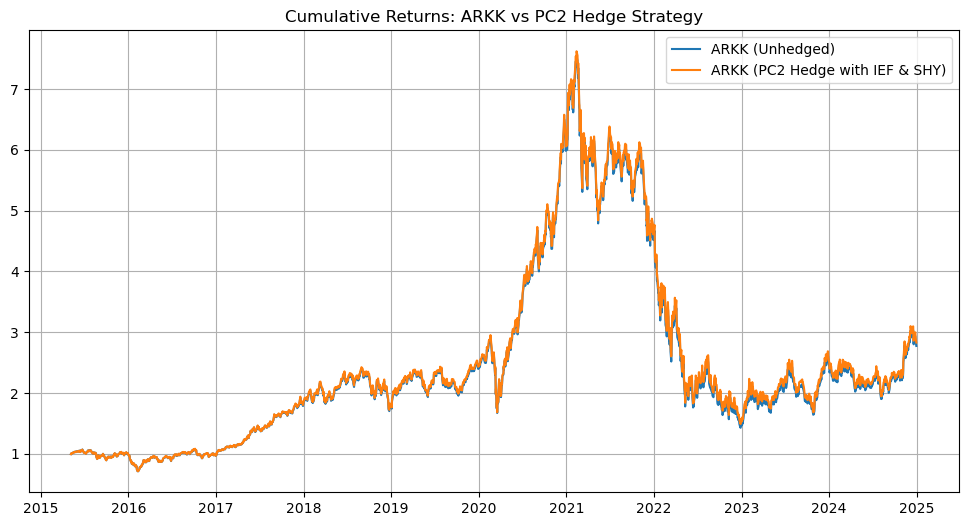

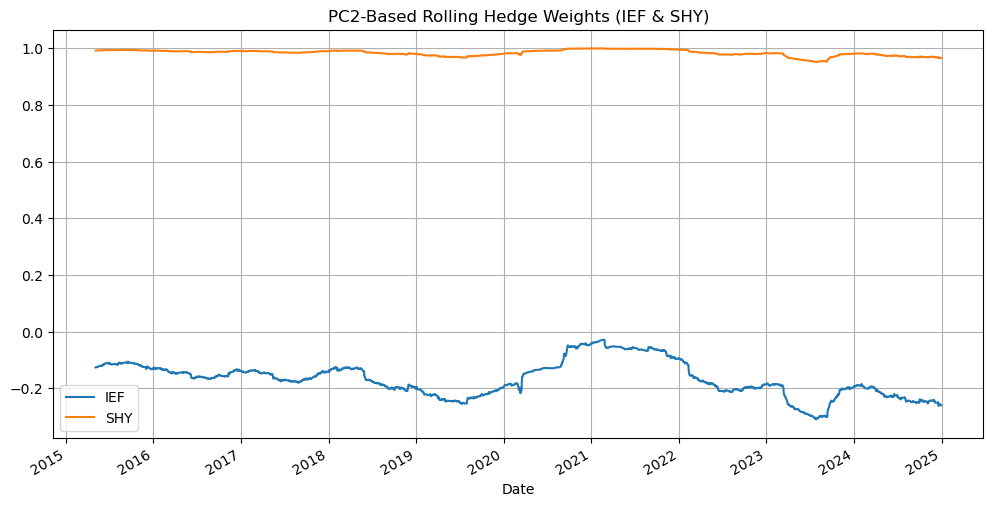

In [317]:
hedging_tickers = ['IEF', 'SHY']
hedge_weights = []
hedged_returns = []

# Rolling PCA application
for i in range(window, len(returns)):
    # Window slice
    window_data = returns[hedging_tickers].iloc[i-window:i]
    
    # PCA fitting
    pca = PCA(n_components=2)
    pca.fit(window_data)
    
    # Extract PC2 loadings (focus on curve steepening)
    pc2_loadings = pca.components_[1]
    hedge_weights.append(pc2_loadings)
    
    # Apply hedge for the current day
    hedge_effect = np.dot(pc2_loadings, returns[['IEF', 'SHY']].iloc[i].values)
    hedged_return = returns['ARKK'].iloc[i] - hedge_effect
    hedged_returns.append(hedged_return)

# Convert to DataFrame for easier analysis
hedged_returns = pd.Series(hedged_returns, index=returns.index[window:])
hedge_weights_df = pd.DataFrame(hedge_weights, columns=['IEF', 'SHY'], index=returns.index[window:])

# Plot cumulative returns
cumulative_arkk = (1 + returns['ARKK'].loc[hedged_returns.index]).cumprod()
cumulative_hedged = (1 + hedged_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_arkk, label='ARKK (Unhedged)')
plt.plot(cumulative_hedged, label='ARKK (PC2 Hedge with IEF & SHY)')
plt.title('Cumulative Returns: ARKK vs PC2 Hedge Strategy')
plt.legend()
plt.grid(True)
plt.show()

# Plot rolling hedge weights
hedge_weights_df.plot(figsize=(12, 6))
plt.title("PC2-Based Rolling Hedge Weights (IEF & SHY)")
plt.grid(True)
plt.show()



In [319]:
performance_summary = {
    "ARKK Final Value": cumulative_arkk.iloc[-1],
    "Hedged ARKK Final Value": cumulative_hedged.iloc[-1],
    "ARKK Volatility": returns['ARKK'].std() * (252 ** 0.5),
    "Hedged ARKK Volatility": hedged_returns.std() * (252 ** 0.5)
}

print("\nPerformance Summary:")
for key, value in performance_summary.items():
    print(f"{key}: {value:.4f}")


Performance Summary:
ARKK Final Value: 2.7737
Hedged ARKK Final Value: 2.8297
ARKK Volatility: 0.3771
Hedged ARKK Volatility: 0.3846


Rolling Regression Beta Hedge Using ETF

Hit the cap on 1.9% of days
             Unhedged  Gross Hedge  Net Hedge
Final Value  2.815738     3.618297   2.952309
Volatility   0.392454     0.390056   0.390146
Sharpe       0.485198     0.556235   0.499299


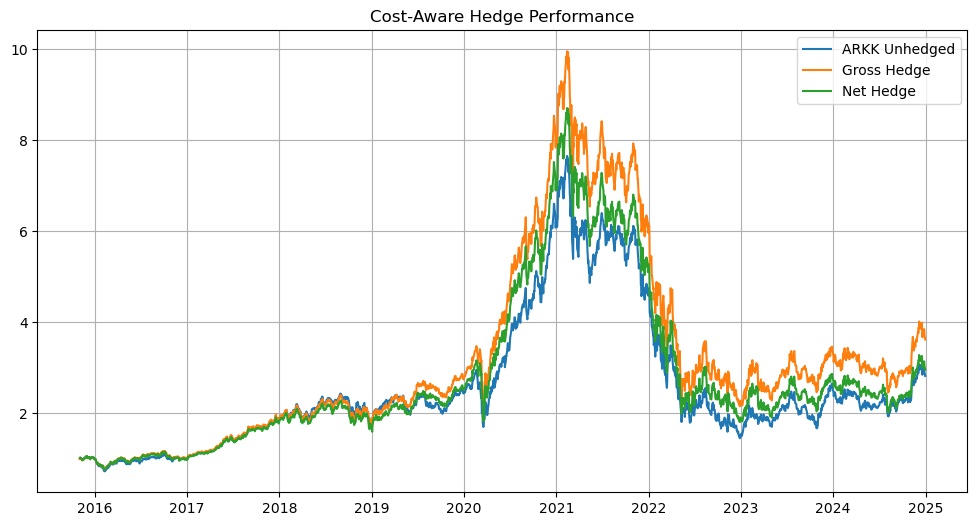

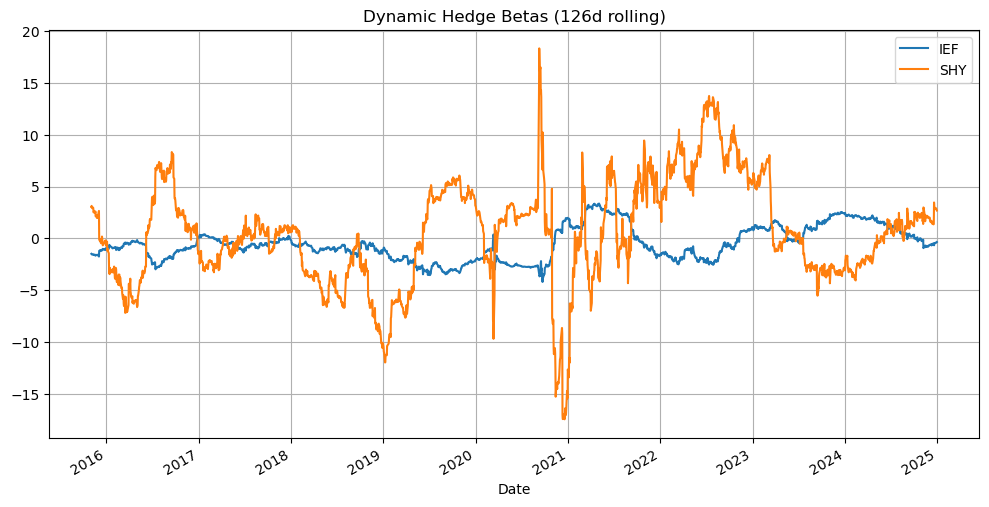

In [322]:
window = 126
hedging_tickers = ['IEF', 'SHY']
betas_dynamic = pd.DataFrame(index=returns.index, columns=['const'] + hedging_tickers)

for i in range(window, len(returns)):
    y = returns['ARKK'].iloc[i-window:i]
    # X = sm.add_constant(returns[['TLT','IEF','SHY']].iloc[i-window:i])
    X = sm.add_constant(returns[hedging_tickers].iloc[i-window:i])
    mdl = sm.OLS(y, X).fit()
    betas_dynamic.iloc[i] = mdl.params

betas_dynamic = betas_dynamic.dropna()
mask = betas_dynamic.index

returns = returns.loc[mask]

gross_hedged = returns.loc[mask, 'ARKK'] - (
    # betas_dynamic['TLT'] * returns['TLT'].loc[betas_dynamic.index] +
    betas_dynamic['IEF'] * returns['IEF'] +
    betas_dynamic['SHY'] * returns['SHY']
)

hedge_pct_cap = 10

gross_pct = betas_dynamic.sum(axis=1)
scale = np.where(gross_pct.abs() > hedge_pct_cap, hedge_pct_cap / gross_pct, 1.0)

cap_hits = (gross_pct > hedge_pct_cap).mean()
print(f"Hit the cap on {cap_hits:.1%} of days")

gross_hedged = returns['ARKK'] - (
    betas_dynamic['IEF'] * scale * returns['IEF'] +
    betas_dynamic['SHY'] * scale * returns['SHY']
)

# 5. Position sizing and cost assumptions
N = 9_000_000_000  # $9B notional
trade_cost_pct = {'TLT': 0.0001, 'IEF': 0.0001, 'SHY': 0.0001}
borrow_rate = {'TLT': 0.004, 'IEF': 0.004, 'SHY': 0.004}

prices = data[hedging_tickers].loc[betas_dynamic.index]

# 6. Daily positions (shares)
positions = betas_dynamic[hedging_tickers].multiply(N).divide(prices)

# 7. Turnover and trade cost
shares_diff = positions.diff().abs()
turnover_value = shares_diff.multiply(prices)
daily_trade_cost = sum(turnover_value[col] * trade_cost_pct[col] for col in turnover_value.columns)

# 8. Borrow cost for shorts
short_shares = positions.clip(upper=0).abs()
borrow_cost = sum(short_shares[col] * prices[col] * (borrow_rate[col]/252) for col in short_shares.columns)

# 9. Net hedged returns
daily_cost = (daily_trade_cost + borrow_cost) / N
net_hedged = gross_hedged - daily_cost

# 10. Performance stats
def perf_stats(r):
    return pd.Series({
        'Final Value': (1+r).cumprod().iloc[-1],
        'Volatility': r.std()*np.sqrt(252),
        'Sharpe': r.mean()/r.std()*np.sqrt(252)
    })

idx = gross_hedged.index
stats = pd.DataFrame({
    'Unhedged': perf_stats(returns['ARKK'].loc[idx]),
    'Gross Hedge': perf_stats(gross_hedged),
    'Net Hedge': perf_stats(net_hedged)
})

print(stats)

# 11. Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot((1+returns['ARKK'].loc[idx]).cumprod(), label='ARKK Unhedged')
plt.plot((1+gross_hedged).cumprod(), label='Gross Hedge')
plt.plot((1+net_hedged).cumprod(), label='Net Hedge')
plt.legend(); plt.title('Cost‐Aware Hedge Performance'); plt.grid(True)
plt.show()

# 12. Plot rolling betas
betas_dynamic[hedging_tickers].plot(figsize=(12,6))
plt.title('Dynamic Hedge Betas (126d rolling)'); plt.grid(True)
plt.show()

Compute Hedge Notional

6.217031551858232


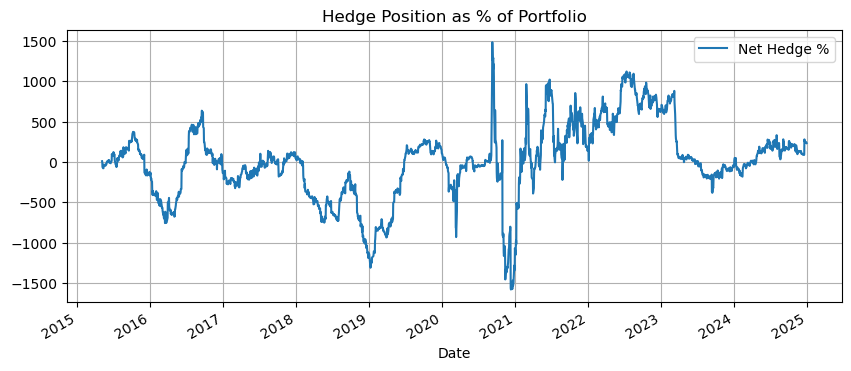

In [242]:

V = (1 + returns['ARKK']).cumprod()
net_hedge_pct = betas_dynamic[hedging_tickers].sum(axis=1) * 100

# 5) Inspect or plot:
print(net_hedge_pct.mean())

# 6) Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
net_hedge_pct.plot(label='Net Hedge %')
plt.legend(); plt.title("Hedge Position as % of Portfolio"); plt.grid(True)

In [299]:
gross_pct

Date
2015-05-06    0.102627
2015-05-07   -0.020136
2015-05-08   -0.613908
2015-05-11   -0.767383
2015-05-12   -0.765915
                ...   
2024-12-23    2.436812
2024-12-24    2.425601
2024-12-26    2.490665
2024-12-27    2.477588
2024-12-30    2.344278
Length: 2430, dtype: object

Rolling Regression Beta Hedge Using Treasury Note Futures

In [46]:

# https://www.cmegroup.com/trading/interest-rates/basics-of-us-treasury-futures.html


window = 126
hedging_symbols = ['ZT=F', 'ZF=F', 'ZN=F']
# Path to your CSV:
csv_path = 'data/arkk_tnote_futures.csv'
N = 9_000_000_000       # $9 B portfolio
cm = 1000               # $1 000 per futures point
cost_per_contract = 10
initial_margin = 1875   # USD per contract
fin_rate = 0.02         # 2% annual funding

In [47]:
returns = data.pct_change().dropna()

/var/folders/y2/0_482wmd2w79jngp561b2h580000gn/T/ipykernel_23665/1517689983.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


In [ ]:
data = pd.read_csv(csv_path, index_col=0, parse_dates=True).sort_index()

# === 2. Compute P&L series ===
pnl = pd.DataFrame(index=data.index)
pnl['ARKK'] = data['ARKK'].pct_change() * N
pnl[hedging_symbols] = data[hedging_symbols].diff()  * cm
pnl.dropna(inplace=True)

# === 3. Rolling OLS to estimate contract betas per $1 ===
betas = pd.DataFrame(index=pnl.index, columns=hedging_symbols)
for i in range(window, len(pnl)):
    y = pnl['ARKK'].iloc[i-window:i]
    X = sm.add_constant(pnl[hedging_symbols].iloc[i-window:i])
    model = sm.OLS(y, X).fit()
    betas.iloc[i] = model.params[hedging_symbols]
betas.dropna(inplace=True)

# === 4. Quarterly rebalancing schedule ===
rebal_dates = betas.groupby(pd.Grouper(freq='Q')).apply(lambda df: df.index[-1]).values

# === 5. Build quarterly-rebalanced positions (contracts) ===
positions = -betas  # contracts per N notional
positions_q = positions.loc[rebal_dates]
positions_ffill = positions_q.reindex(positions.index).ffill()

# === 6. Hedge P&L & returns ===
hedged_pnl = pnl['ARKK'] + (positions_ffill * pnl[hedging_symbols]).sum(axis=1)
hedged_returns = hedged_pnl / N
arkk_returns = pnl['ARKK'] / N

# === 7. Cost components ===
# 7a. Transaction cost on rebal dates only
turnover = positions_ffill.diff().abs().fillna(0)
turnover.loc[~turnover.index.isin(rebal_dates)] = 0
transaction_cost = turnover.sum(axis=1) * cost_per_contract / N

# 7b. Daily margin financing cost
daily_margin_cost = (positions_ffill.abs() * initial_margin * (fin_rate/252)).sum(axis=1) / N

# 8. Net hedged returns
net_returns = hedged_returns - transaction_cost - daily_margin_cost

/var/folders/y2/0_482wmd2w79jngp561b2h580000gn/T/ipykernel_23665/1276865460.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  rebal_dates = betas.groupby(pd.Grouper(freq='Q')).apply(lambda df: df.index[-1]).values
/var/folders/y2/0_482wmd2w79jngp561b2h580000gn/T/ipykernel_23665/1276865460.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  betas_rebal = betas_q.reindex(returns.index).ffill()


              Unhedged  Gross Hedge  Net Hedge (Qtr)
Final Value   3.183441     3.184991         0.009121
Volatility    0.387075     0.387060         0.388424
Sharpe Ratio  0.482387     0.482512        -0.970697


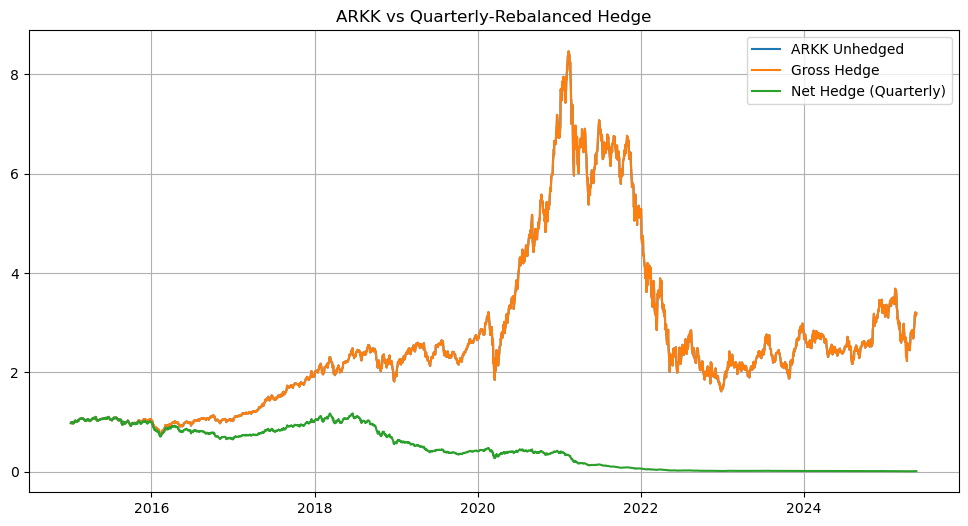

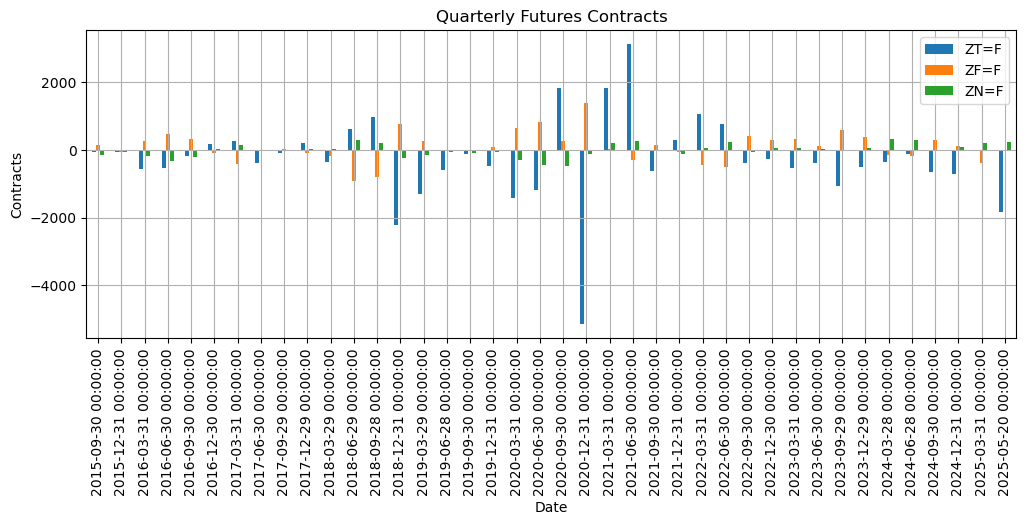

In [ ]:
def perf_stats(r):
    return pd.Series({
        'Final Value': (1 + r).cumprod().iloc[-1],
        'Volatility': r.std() * np.sqrt(252),
        'Sharpe Ratio': r.mean() / r.std() * np.sqrt(252)
    })

idx = net_returns.index
metrics = pd.DataFrame({
    'Unhedged': perf_stats(arkk_returns.loc[idx]),
    'Gross Hedge': perf_stats(hedged_returns.loc[idx]),
    'Net Hedge': perf_stats(net_returns.loc[idx])
})
print(metrics)

# === 10. Plot cumulative returns ===
plt.figure(figsize=(10,6))
plt.plot((1+arkk_returns.loc[idx]).cumprod(), label='ARKK Unhedged')
plt.plot((1+hedged_returns.loc[idx]).cumprod(), label='Gross Hedge')
plt.plot((1+net_returns.loc[idx]).cumprod(), label='Net Hedge (Cost-Aware)')
plt.title('ARKK vs Quarterly-Rebalanced Futures Hedge (All Costs)')
plt.legend(); plt.grid(True)
plt.show()

# === 11. Plot contract schedules ===
positions_ffill.loc[rebal_dates].plot(kind='bar', figsize=(10,4))
plt.title('Quarterly Futures Contracts')
plt.ylabel('Contracts per $9B')
plt.grid(True)
plt.show()

In [41]:
positions_ffill.diff().fillna(0)

,ZT=F,ZF=F,ZN=F
Date,,,
2015-07-07,0.000000e+00,0.000000,0.000000
2015-07-08,0.000000e+00,0.000000,0.000000
2015-07-09,0.000000e+00,0.000000,0.000000
2015-07-10,0.000000e+00,0.000000,0.000000
2015-07-13,0.000000e+00,0.000000,0.000000
...,...,...,...
2025-05-14,0.000000e+00,0.000000,0.000000
2025-05-15,0.000000e+00,0.000000,0.000000
2025-05-16,0.000000e+00,0.000000,0.000000
